In [1]:
import ee
import geemap
import math

In [2]:
cloud_project = 'ee-robertzakayo4'

try:
    ee.Initialize(project=cloud_project)
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project)

In [3]:
m = geemap.Map(width=800)

In [4]:
gcp = ee.FeatureCollection('projects/ee-robertzakayo4/assets/gcps_updated')
rice_wet = ee.FeatureCollection('projects/ee-robertzakayo4/assets/Rice_wet')
none_rice = ee.FeatureCollection('projects/ee-robertzakayo4/assets/None_RiceWet')

In [7]:
AOI = ee.FeatureCollection('projects/ee-robertzakayo4/assets/AreaOfInterest')
geometry = AOI.geometry()
m.centerObject(geometry, 10)
m.addLayer(AOI, {}, 'Area of Interest')
m

Map(bottom=119592.0, center=[15.967129514062975, 120.74045665287467], controls=(WidgetControl(options=['positi…

In [8]:
# Load the Composite
# This was Exported as an Asset previously
composite = ee.Image('projects/ee-robertzakayo4/assets/Image_dry2023')
#visParams = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 3000, "gamma": 1.2}
m.addLayer(composite.clip(geometry))
m

Map(bottom=119592.0, center=[15.967129514062975, 120.74045665287467], controls=(WidgetControl(options=['positi…

In [9]:
# Normalize the image
# Function to Normalize Image
# Pixel Values should be between 0 and 1
# Formula is (x - xmin) / (xmax - xmin)
#**************************************************************************
def normalize(image):
    bandNames = image.bandNames()
    # Compute min and max of the image
    minDict = image.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=geometry,
    scale=10,
    maxPixels=1e9,
    bestEffort=True,
    tileScale=16
    )
    maxDict = image.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=geometry,
    scale=10,
    maxPixels=1e9,
    bestEffort=True,
    tileScale=16
    )
    mins = ee.Image.constant(minDict.values(bandNames))
    maxs = ee.Image.constant(maxDict.values(bandNames))

    normalized = image.subtract(mins).divide(maxs.subtract(mins))
    return normalized

composite = normalize(composite)

In [10]:
# Add a random column and split the GCPs into training and validation set
gcp = gcp.randomColumn()

# for validation. Normal recommended ratio is
# 70% training, 30% validation
trainingGcp = gcp.filter(ee.Filter.lt('random', 0.6))
validationGcp = gcp.filter(ee.Filter.gte('random', 0.6))

# Overlay the point on the image to get training data.
training = composite.sampleRegions(
collection=trainingGcp,
properties=['class'],
scale=10,
tileScale=16
)
print(training.getInfo())

{'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'VV', 'VH', 'ndvi', 'ndbi', 'mndwi', 'bsi', 'elev', 'slope']}, 'features': [{'type': 'Feature', 'geometry': None, 'id': '00000000000000000003_0', 'properties': {'B1': 0.05283757639932292, 'B11': 0.3426796461775682, 'B12': 0.18622429026349085, 'B2': 0.03650745271769541, 'B3': 0.0774585347986308, 'B4': 0.05800747588836077, 'B5': 0.13803626845547473, 'B6': 0.3700331698687027, 'B7': 0.4340499621050587, 'B8': 0.3937319423506709, 'B8A': 0.45555374583162705, 'B9': 0.6095749906748558, 'VH': 0.33092762754215277, 'VV': 0.3446776339669979, 'bsi': 0.4504541112376948, 'class': 1, 'elev': 0.08256880939006805, 'mndwi': 0.17363546337510333, 'ndbi': 0.3820107492705212, 'ndvi': 0.8404740504341227, 'slope': 0.0492452191816057}}, {'type': 'Feature', 'geometry': None, 'id': '00000000000000000004_0', 'properties': {'B1': 0.03693737988205209, 'B11': 0.334832009

In [11]:
# Train a classifier.
classifier = ee.Classifier.smileRandomForest(50).train(
features=training,
classProperty='class',
inputProperties=composite.bandNames()
)


In [14]:
# Feature Importance
#**************************************************************************

# Run .explain() to see what the classifer looks like
print(classifier.explain().getInfo())

# Calculate variable importance
importance = ee.Dictionary(classifier.explain().get('importance'))

# Calculate relative importance
sum = importance.values().reduce(ee.Reducer.sum())

def Importance(key, val):
    return (ee.Number(val).multiply(100)).divide(sum)

relative_Importance = importance.map(Importance)
# Get importance values as dictionary
relative_importance_dict = relative_Importance.getInfo() if relative_Importance else {}

print(relativeImportance.getInfo())

{'classes': [0, 1, 2, 3, 4], 'importance': {'B1': 89.14684344749391, 'B11': 84.11969879091168, 'B12': 84.29254983130541, 'B2': 94.1524693907849, 'B3': 86.2531194019425, 'B4': 84.5822867409543, 'B5': 88.54819488067315, 'B6': 71.02902836783434, 'B7': 71.79325629756285, 'B8': 73.89820520641591, 'B8A': 79.298670402907, 'B9': 79.42265682286832, 'VH': 109.92809380604719, 'VV': 105.78676445003735, 'bsi': 79.55843303714283, 'elev': 139.54585697155642, 'mndwi': 87.34648279896781, 'ndbi': 72.40397459440159, 'ndvi': 87.12330422473029, 'slope': 75.62969803780108}, 'numberOfTrees': 50, 'outOfBagErrorEstimate': 0.05826446280991736, 'trees': ['n= 2421\nnode), split, n, loss, yval, (yprob)\n* denotes terminal node\n1) root 2421 1630.5 2 (0.042045 0.088623 0.45466 0.098516 0.31616)\n 2) B2<=0.0867052 1176 631.17 4 (0.081287 0.16342 0.027096 0.079594 0.64860)\n  4) VH<=0.358927 371 254.00 1 (0.20479 0.44681 0.0079787 0.25000 0.090426)\n   8) B9<=0.341179 91 0.0000 3 (0.010417 0.010417 0.010417 0.95833 0

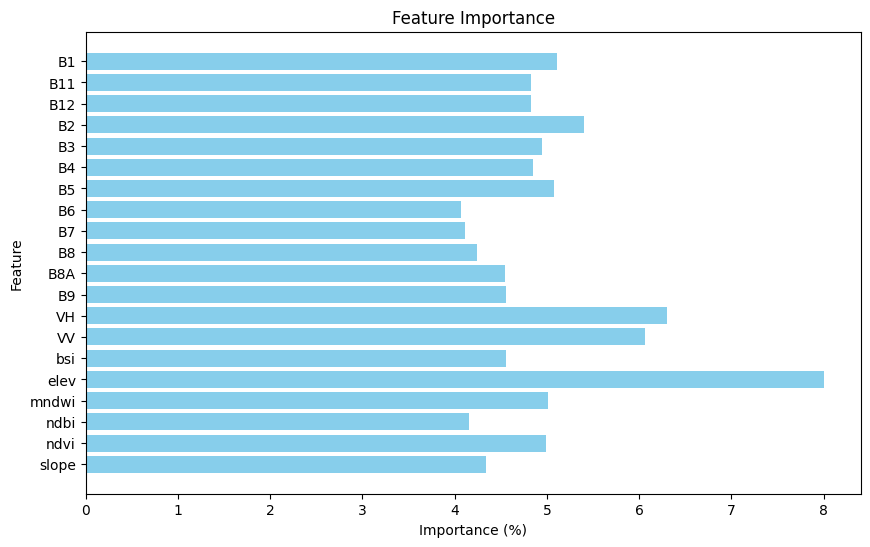

In [16]:
import matplotlib.pyplot as plt
# Create a FeatureCollection for visualization
importance_fc = ee.FeatureCollection([
    ee.Feature(None, relativeImportance)
])

# Convert dictionary to lists for plotting
features = list(relative_importance_dict.keys())
importances = list(relative_importance_dict.values())

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

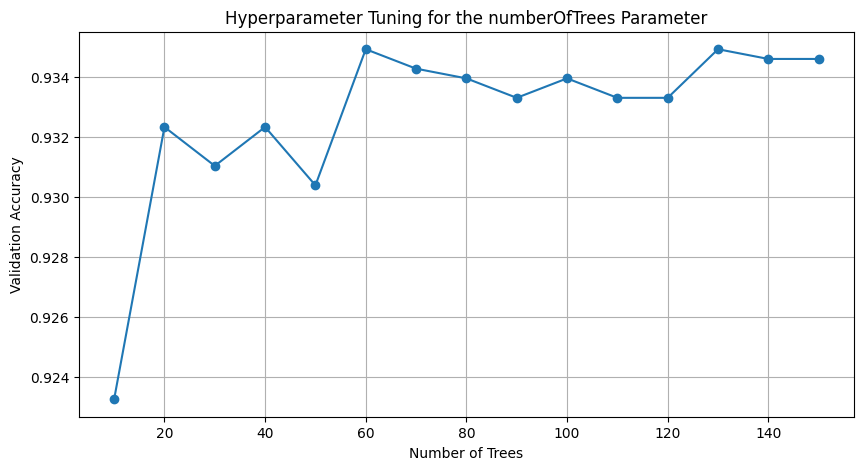

In [17]:
# Hyperparameter Tuning
#**************************************************************************

test = composite.sampleRegions(
collection=validationGcp,
properties=['class'],
scale=10,
tileScale=16
)

# Tune the numberOfTrees parameter.
numTreesList = ee.List.sequence(10, 150, 10)

def Tunning(numTrees):
    classifier = ee.Classifier.smileRandomForest(numTrees) \
    .train(
        features=training,
        classProperty='class',
        inputProperties=composite.bandNames()
        )

    # Here we are classifying a table instead of an image
    # Classifiers work on both images and tables
    return test \
    .classify(classifier) \
    .errorMatrix('class', 'classification') \
    .accuracy()

accuracies = numTreesList.map(Tunning)

# Convert results to a list and print
accuracies_list = accuracies.getInfo()
num_trees_list = numTreesList.getInfo()

# Visualize using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(num_trees_list, accuracies_list, marker='o', linestyle='-')
plt.xlabel('Number of Trees')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Tuning for the numberOfTrees Parameter')
plt.grid(True)
plt.show()


In [21]:
# Tuning Multiple Parameters
#  using nested map() functions
# Let's tune 2 parameters
# numTrees and bagFraction
numTreesList = ee.List.sequence(10, 150, 10)
bagFractionList = ee.List.sequence(0.1, 0.9, 0.1)

# Function to tune parameters
def tune_parameters(numTrees):
    def inner_tune(bagFraction):
        classifier = ee.Classifier.smileRandomForest(
            numberOfTrees=numTrees, bagFraction=bagFraction
        ).train(
            features=training,
            classProperty='class',
            inputProperties=composite.bandNames()
        )

        accuracy = test.classify(classifier).errorMatrix('class', 'classification').accuracy()
        return ee.Feature(None, {
            'accuracy': accuracy,
            'numTrees': numTrees,
            'bagFraction': bagFraction
        })

    return bagFractionList.map(inner_tune)

# Collect all accuracies
accuracies = numTreesList.map(tune_parameters).flatten()

# Convert to FeatureCollection
tuning_results = ee.FeatureCollection(accuracies)

# Find the best model based on accuracy
best_model = tuning_results.sort('accuracy', False).first()
optimalNumTrees = best_model.get('numTrees')
optimalBagFraction = best_model.get('bagFraction')

# Train the final model
optimalModel = ee.Classifier.smileRandomForest(
    numberOfTrees=optimalNumTrees,
    bagFraction=optimalBagFraction
).train(
    features=training,
    classProperty='class',
    inputProperties=composite.bandNames()
)

# Classify the composite image
Classification_dry = composite.classify(optimalModel)

In [22]:
print(Classification_dry.getInfo())

{'type': 'Image', 'bands': [{'id': 'classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'dimensions': [2360, 2312], 'crs': 'EPSG:4326', 'crs_transform': [8.983152841195215e-05, 0, 120.62748315060917, 0, -8.983152841195215e-05, 16.09259966277393]}], 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[120.6275163348643, 15.884864841754462], [120.62752809699946, 15.88486412765275], [120.73348436393675, 15.884864055929135], [120.83944061626502, 15.88486410449835], [120.8394837292297, 15.884900662603112], [120.83953131120369, 15.884931729914884], [120.83953420292525, 15.884946518271454], [120.83953429055319, 16.09255474840583], [120.83949626002757, 16.09259619727196], [120.83946392530878, 16.092641934815635], [120.8394485027841, 16.09264470684918], [120.73348436393675, 16.092644707234385], [120.62752800922233, 16.09264475457201], [120.62748491064708, 16.09260816593544], [120.62743733542065, 16.092577085841164

In [24]:
# Define visualization parameters
palette = ['#cc6d8f', '#ffc107', '#1e88e5', '#004d40']

# Create map
m = geemap.Map()
m.centerObject(geometry, 10)
m.addLayer(Classification_dry.clip(geometry), {"min": 0, "max": 5, "palette": palette}, 'Rice Classification')
m

Map(center=[15.967129514062975, 120.74045665287467], controls=(WidgetControl(options=['position', 'transparent…

In [25]:
#***********Acurracy assessment******************************#
test = Classification_dry.sampleRegions(
collection=validationGcp,
properties=['class'],
tileScale=16,
scale=10,
)

print(test.getInfo())
testConfusionMatrix = test.errorMatrix('class', 'classification')
# Printing of confusion matrix may time out. Alternatively, you can export it as CSV
print('Confusion Matrix', testConfusionMatrix.getInfo())
print('Test Accuracy', testConfusionMatrix.accuracy().getInfo())

{'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['classification']}, 'features': [{'type': 'Feature', 'geometry': None, 'id': '00000000000000000000_0', 'properties': {'class': 1, 'classification': 0}}, {'type': 'Feature', 'geometry': None, 'id': '00000000000000000001_0', 'properties': {'class': 1, 'classification': 1}}, {'type': 'Feature', 'geometry': None, 'id': '00000000000000000002_0', 'properties': {'class': 1, 'classification': 4}}, {'type': 'Feature', 'geometry': None, 'id': '00000000000000000006_0', 'properties': {'class': 1, 'classification': 1}}, {'type': 'Feature', 'geometry': None, 'id': '00000000000000000009_0', 'properties': {'class': 1, 'classification': 1}}, {'type': 'Feature', 'geometry': None, 'id': '0000000000000000000d_0', 'properties': {'class': 1, 'classification': 2}}, {'type': 'Feature', 'geometry': None, 'id': '00000000000000000011_0', 'properties': {'class': 1, 'classification': 0}}, {'type': 'Feature', 'geometry': None, 'id': '0000000

In [26]:
outline = ee.Image().byte().paint(
featureCollection=rice_wet,
color=1,
width=3
)

m.addLayer(outline, {"palette": 'red'}, 'rice_wet')

outline = ee.Image().byte().paint(
featureCollection=none_rice,
color=1,
width=3
)

m.setOptions('HYBRID')
m.addLayer(outline, {"palette": 'blue'}, 'none_rice')
m

Map(bottom=119592.0, center=[15.967129514062975, 120.74045665287467], controls=(WidgetControl(options=['positi…

In [ ]:
# Export.image.toDrive(
#   "image" =Classification_dry.clip(geometry),
#   "description" ='Classification_2024',
#   "folder" ='GEE',
#   "fileNamePrefix" ='ClassificationImage_2024',
#   "region" =geometry,
#   "scale" =10,
#   "maxPixels" =1e10 })

In [ ]:
# geemap.ee_export_image_to_asset(
#   "image" =Classification_dry.clip(geometry),
#   "description" ='Classification_2024',
#   "assetId" ='projects/ee-robertzakayo4/assets/Classification_2024',
#   "pyramidingPolicy" ={'default' ='mode'},
#   "region" =geometry,
#   "scale" =10,
#   "maxPixels" =1e10 })

In [27]:
# Printing or Displaying the image may time out as it requires
# extensive computation to find the optimal parameters

# Export the 'finalClassification' to Asset and import the
# result to view it.

# Convert the trained classifier to a JSON dictionary
classifierDescription = optimalModel.explain()

# Save the classifier as a FeatureCollection with properties
classifierFeature = ee.Feature(None, classifierDescription)
classifierFC = ee.FeatureCollection([classifierFeature])

# Export to an Asset
#geemap.ee_export_vector_to_asset(
#collection=classifierFC,
#description='Classifier_OptimalModel',
#assetId='projects/ee-robertzakayo4/assets/OptimalRFModel'
#)
#m